In [ ]:
# La práctica deberá realizarse de manera individual y debe entregarse en la plataforma de Instituto BME.

# Para cada ejercicio: 1) Entregad un fichero en ipython notebook (.ipynb) ejecutable en Colab, y 
# 2) cada notebook ha de incluir un comentario sobre el ejercicio y sus resultados.

# 6) Modifica el entorno de RL-Bolsa para:
# a- Meter comisiones. IMPLEMENTADO. Veas class OneStockEnv_vender_porcion_porc_comis.


# - Aceptar inversion en corto. NO IMPLEMENTADO. Veas class OneStockEnv_vender_porcion_porc_comis.
# Lo unico que he hecho es quitarle la penalizacion de si vendes antes de comprar

# c- Modificar el precio de salida teniendo en cuenta el impacto de nuestra 
# compra en caso de que se haga la acción de “comprar”, o “vender”. IMPLEMENTADO
# Veas class OneStockEnv_vender_porcion_porc_comis.
# si compro afecto un 0.01% el valor del precio de compra hacia arriba 
# (por el procentaje de lo que voy a comprar).
# si vendo afecto un 0.01% el valor del precio de venta hacia abajo 
# (por el porcentaje de lo que voy a comprar).

# d- Incluir ruido en los datos. IMPLEMENTADO. Veas class OneStockEnv_vender_porcion_porc_comis.
# considero que meter ruido en los datos es que 
# algunos datos no se tenian y entonces se rellenaban con los del dia anterior
# Genero en y un 10% de datos a 0

# e- Algo que a tu pienses que es interesante. IMPLEMENTADO. Veas class OneStockEnv_vender_porcion_porc_comis.
# Porcentaje de lo que vendo en una tercera variable de entrada al 
# step(self, action,porcion) llamada porcion al sell
# Compro una proporcion que pueden ser 2 acciones o 3, etc en una 
# tercera variable de entrada al step(self, action,porcion) 
# llamada porcion al buy.

In [ ]:
# TOMO COMO REFERENCIA RL_StockMarket_development_env_simple_clase.ipynb

In [ ]:
# 0 Inicializo librerias
# Libraries
# Basics
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt

# Reinforcement Learning
import gym
from gym import spaces

In [ ]:
# 1 Importo DATA
# Import data
data = pd.read_csv("googl.us.txt", delimiter=",")

# d. Incluir ruido en los datos.
# considero que meter ruido en los datos es que 
# algunos datos no se tenian y entonces se rellenaban con los del dia anterior
data = data['Open']
# viejo
#Genero en y un 10% de datos a 0
cuantos_random = int(data.shape[0]*0.1)
a_acero_array = []
for i in range(0,cuantos_random):
    a_cero = np.random.randint(0, data.shape[0])
    a_acero_array.append(a_cero)
data[a_acero_array] = np.nan
# pd.DataFrame(data).plot(figsize=(20,10))
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
# pd.DataFrame(data).plot(figsize=(20,10))

# vector_incertidumbre = np.full(shape = y.shape[0], fill_value = 100, dtype=None)
# vector_incertidumbre[a_acero_array] = 0
# pd.DataFrame(vector_incertidumbre).plot(figsize=(20,10))
# y, y.shape, vector_incertidumbre, vector_incertidumbre.shape

In [ ]:
# 2 DEFINITION OF ENVIRONMENT
# Como hemos dicho, un entorno comprende todo lo que está fuera del agente, 
# por lo que su código de implementación debe contener toda la funcionalidad 
# que permita al agente interactuar con él y aprender. Vamos a implementar 
# este entorno siguiendo las directrices de OpenAI gym [1], una de las 
# librerías más utilizadas para desarrollar aplicaciones de aprendizaje 
# por refuerzo. Los entornos se definen como una clase con los siguientes métodos:

# init(self): define la información inicial del entorno como el espacio de 
# observación o el espacio de acción.
# reset(self): reinicia el estado del entorno.
# step(self, action): avanza el entorno un paso de tiempo. Devuelve
# - observación (objeto): un objeto específico del entorno que representa 
# nuestra observación del entorno.
# - reward (float): cantidad de recompensa obtenida por la acción anterior.
# - done (boolean): si es el momento de reiniciar el entorno de nuevo.
# - info (dict): información de diagnóstico útil para la depuración.

# render(self, mode='human'): renderiza un fotograma del entorno.

# Un entorno de acciones
# Lo primero que necesitamos es definir cómo debe percibir un agente su entorno, 
# es decir, tenemos que considerar cómo realizará la tarea un humano. 
# Para formular el problema de RL, necesitamos definir tres cosas:
# 1) Observations: podemos pensar en qué tipo de observaciones utiliza un humano 
# a la hora de operar. Como primera aproximación vamos a utilizar sólo valores históricos 
# de precios, donde cada paso de tiempo tiene los precios de apertura, cierre, mínimo y máximo de ese día.
# 2) Accions: hay tres acciones posibles en cada momento:
# 2.1) Hold:  no hacer nada, es decir, saltarse el paso de tiempo sin tomar acciones.
# 2.2) Buy: abrir una posición, es decir, comprar una acción y guardar el precio en 
# ese momento para calcular el beneficio.
# 2.3) Sell: cerrar una posición, es decir, vender una acción y guardar el precio en 
# ese momento para calcular el beneficio.
# Rewards: como primera aproximación podemos utilizar los beneficios.

# CLASE PARCIAL DEL EJERCICIO
class OneStockEnv(gym.Env):
    '''
    Reinforcement Leaning environment representing a Stock Market with a single stock.
    '''
    def __init__(self, 
                 data,
                 time_skip    = 1,
                 time_horizon = 10,
                 # comision = 0 #a.  Meter comisiones. Porcentqaje comision
                 porcentaje_comision = 0.0007 #a.  Meter comisiones. Porcentqaje comision
                 ):
        '''
        Initialization of the environment.
        
        Args:
            data
            time_skip    (int):      number of timesteps to skip between states
        '''
        # Get the data
        self.data = data
        self.time_horizon = time_horizon
        self.time_skip = time_skip
        #self.comision = comision #a.  Meter comisiones. Porcentqaje comision
        self.porcentaje_comision = porcentaje_comision #a.  Meter comisiones. Porcentqaje comision
        # Define actions
        self.actions = {0 : 'Hold', 1 : 'Buy', 2 : 'Sell'}
        
        # Save useful values
        self.n_timesteps = (self.data.shape[0] - self.time_horizon) 
        self.n_features  = 1
        self.n_actions   = len(self.actions)
        self.state_shape = (self.time_horizon, self.n_features)
        
        # Define spaces
        self.action_space      = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.state_shape, dtype=np.float32)

        # Initialize the environment
        self.reset()
        
        
        
    
    def reset(self):
        '''
        Initalize temporal variables.
        '''
        # Intialize the values
        self.t = self.time_horizon
        self.positions_opened = []
        
        self.position_value = 0
        self.done = False
        
            

        # Define some useful debug variables
        self.history_dates = []
        self.history_actions = []
        self.history_position_values = []
        self.history_profits = []
        self.history_rewards = []
        
        # Get first state
        # initial_state = self.data[:self.t]
        # initial_state = np.array(initial_state).reshape(1,self.time_horizon,self.n_features)

        self.next_state = self.data[(self.t - self.time_horizon):self.t]
        self.next_state = np.array(self.next_state).reshape(1,self.time_horizon,self.n_features)
        
        return self.next_state

    def step(self, action):
        # Compute position value and profits
        position_value = sum([self.data[self.t] for p in self.positions_opened])
        profits        = sum([self.data[self.t] - p for p in self.positions_opened])

        # Hold
        if action == 0:
            # Use the profits as reward

            #VAL: Esto no sera? reward = 0
            #reward = profits
            reward = 0
        # Buy
        elif action == 1: 
            # Open a new position
            self.positions_opened.append(self.data[self.t])
            
            # reward = -self.data[self.t-1]-self.comision #a.  Meter comisiones. Porcentaje comision
            reward = -self.data[self.t-1] #a.  Meter comisiones. Porcentaje comision
            reward = reward-(1-self.porcentaje_comision) #a.  Meter comisiones. Porcentaje comision
            en_open_o_en_close = 1
            
        # Sell
        elif action == 2: 
            # Check that the agent as open positions:
            if len(self.positions_opened) > 0:
                # Close all opened positions
                self.positions_opened = []                

                # Use the profits as reward
                # reward = profits
                # reward = self.data[self.t-1]-self.comision #a.  Meter comisiones. Porcentaje comision
                reward = -self.data[self.t-1] #a.  Meter comisiones. Porcentaje comision
                reward = reward-(1-self.porcentaje_comision) #a.  Meter comisiones. Porcentaje comision
                en_open_o_en_close = 0
                
          
                
                
                

            # else: # b.# - Aceptar inversion en corto.
                # Penalize selling when having no opened positions
            #     reward = -1 # b.# - Aceptar inversion en corto.

        # Update debug variables
        #self.history_dates.append(self.data.index[self.t])
        self.history_actions.append(action)
        self.history_position_values.append(position_value)
        self.history_rewards.append(reward)
        
        # Prepare the next step
        self.t += self.time_skip
        self.next_state = self.data[(self.t - self.time_horizon):self.t]
        self.next_state = np.array(self.next_state).reshape(1,self.time_horizon,self.n_features)

        print(self.t)
        # Check if we can continue operating
        if (self.t + self.time_skip) >= len(self.data):
            self.done = True

        # Return (obs, reward, done, info)
        return (self.next_state, reward, self.done, {})

    def render(self, mode = 'human', verbose = False):
        print('PROFITS: {:.3f}'.format(np.sum(self.history_rewards)))
        print('POSITION VALUE: {:.3f}'.format(self.position_value))
        plt.plot(self.next_state[0,:,0])


# CLASE FINAL DEL EJERCICIO
class OneStockEnv_vender_porcion_porc_comis(gym.Env):
    '''
    Reinforcement Leaning environment representing a Stock Market with a single stock.
    '''
    def __init__(self, 
                 data,
                 time_skip    = 1,
                 time_horizon = 10,
                 # comision = 0 #a.  Meter comisiones. Porcentaje comision
                 porcentaje_comision = 0.0007 #a.  Meter comisiones. Porcentaje comision
                 ):
        '''
        Initialization of the environment.
        
        Args:
            data
            time_skip    (int):      number of timesteps to skip between states
        '''
        # Get the data
        self.data = data
        self.time_horizon = time_horizon
        self.time_skip = time_skip
        #self.comision = comision #a.  Meter comisiones. Porcentaje comision
        self.porcentaje_comision = porcentaje_comision #a.  Meter comisiones. Porcentaje comision
        # Define actions
        self.actions = {0 : 'Hold', 1 : 'Buy', 2 : 'Sell'}
        
        # Save useful values
        self.n_timesteps = (self.data.shape[0] - self.time_horizon) 
        self.n_features  = 1
        self.n_actions   = len(self.actions)
        self.state_shape = (self.time_horizon, self.n_features)
        
        # Define spaces
        self.action_space      = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.state_shape, dtype=np.float32)

        # Initialize the environment
        self.reset()
        
        
        
    
    def reset(self):
        '''
        Initalize temporal variables.
        '''
        # Intialize the values
        self.t = self.time_horizon
        self.positions_opened = []
        
        self.position_value = 0
        self.done = False
        
            

        # Define some useful debug variables
        self.history_dates = []
        self.history_actions = []
        self.history_position_values = []
        self.history_profits = []
        self.history_rewards = []
        
        # Get first state
        # initial_state = self.data[:self.t]
        # initial_state = np.array(initial_state).reshape(1,self.time_horizon,self.n_features)

        self.next_state = self.data[(self.t - self.time_horizon):self.t]
        self.next_state = np.array(self.next_state).reshape(1,self.time_horizon,self.n_features)
        
        return self.next_state

    def step(self, action,porcion): # porcion de venta
        # Compute position value and profits
        position_value = sum([self.data[self.t] for p in self.positions_opened])
        profits        = sum([self.data[self.t] - p for p in self.positions_opened])

        # Hold
        if action == 0:
            # Use the profits as reward

            #VAL: Esto no sera? reward = 0
            #reward = profits
            reward = 0
        # Buy
        elif action == 1: 
            
            

            # c. si compro afecto un 0.01% el valor del precio de compra hacia arriba( por el procentaje de lo que voy a comprar)
            print(f'precio de compra original:{self.data[self.t]}') #nuevo. c- Modificar el precio de salida teniendo en cuenta el impacto
            self.data[self.t] = self.data[self.t]*porcion*(1+0.0001) #nuevo c- Modificar el precio de salida teniendo en cuenta el impacto
            print(f'precio de compra afectado final:{self.data[self.t]}') #nuevo c- Modificar el precio de salida teniendo en cuenta el impacto       
           
            # Open a new position
            self.positions_opened.append(self.data[self.t]) # compro una proporcion que pueden ser 2 acioens o 3, etc           
            # reward = -self.data[self.t-1]-self.comision #a.  Meter comisiones. Porcentaje comision
            reward = -self.data[self.t-1] * porcion #a.  Meter comisiones. Porcentaje comision # compro una proporcion que pueden ser 2 acciones o 3, etc
            reward = reward*(1-self.porcentaje_comision) #a.  Meter comisiones. Porcentaje comision
            # en_open_o_en_close = 1
            
        # Sell
        elif action == 2:
            # Check that the agent as open positions:
            if len(self.positions_opened) > 0:
                # Close all opened positions
                a_vender = sum(self.positions_opened) # VENDER PORCION
                self.positions_opened = []
               
                # c. si vendo afecto un 0.01% el valor del precio de venta hacia abajo( por el porcentaje de lo que voy a comprar)
                # pero en este caso entiendo que es t-1
                print(f'precio de venta original:{self.data[self.t-1]}') #nuevo
                self.data[self.t-1] = self.data[self.t-1]*porcion*(1-0.0001) #nuevo
                print(f'precio de venta afectado final:{self.data[self.t-1]}') #nuevo                
               
               
               
                # Use the profits as reward
                # reward = profits
                # reward = self.data[self.t-1]-self.comision #a.  Meter comisiones. Porcentqaje comision # porcentaje de lo que vendo
                reward = -self.data[self.t-1]*porcion #a.  Meter comisiones. Porcentaje comision
                reward = reward*(1-self.porcentaje_comision) #a.  Meter comisiones. Porcentaje comision
               
                # print(-self.data[self.t-1]*(1-porcion))
               
                # print(reward*(1-porcion))
                print(f'total de venta: {a_vender}')
                porcion_no_vendida = a_vender*(1-porcion)# me quedo con la porcion que no he vendido
                print(f'vendido: {a_vender*porcion}')
                self.positions_opened.append(porcion_no_vendida)
                
          
                
                
                

            # else: # b.# - Aceptar inversion en corto.
            #    # Penalize selling when having no opened positions
            #    reward = -1 # b.# - Aceptar inversion en corto.

        # Update debug variables
        #self.history_dates.append(self.data.index[self.t])
        self.history_actions.append(action)
        self.history_position_values.append(position_value)
        self.history_rewards.append(reward)
        
        # Prepare the next step
        self.t += self.time_skip
        self.next_state = self.data[(self.t - self.time_horizon):self.t]
        self.next_state = np.array(self.next_state).reshape(1,self.time_horizon,self.n_features)

        print(self.t)
        # Check if we can continue operating
        if (self.t + self.time_skip) >= len(self.data):
            self.done = True
        
        
        # print(self.next_state) ############
        # Return (obs, reward, done, info)
        return (self.next_state, reward, self.done, {})

    def render(self, mode = 'human', verbose = False):
        print('PROFITS: {:.3f}'.format(np.sum(self.history_rewards)))
        print('POSITION VALUE: {:.3f}'.format(self.position_value))
        plt.plot(self.next_state[0,:,0])

In [ ]:
# A PARTIR DE AQUI ES APRA HACER PRUEBAS DE QUE FUNCIONA

In [ ]:
# Create environment
#env = OneStockEnv(data = data.values,time_horizon = 20,porcentaje_comision=0.0007)
env = OneStockEnv_vender_porcion_porc_comis(data = data.values,time_horizon = 20,porcentaje_comision=0.0007)

In [ ]:
# AGUANTO
next_step, reward, done, _ = env.step(0,0)

33


In [ ]:
# COMPRO
next_step, reward, done, _ = env.step(1,1)

precio de compra original:59.905
precio de compra afectado final:59.9109905
23


In [ ]:
# VENDO
next_step, reward, done, _ = env.step(2,0.5)

precio de venta original:67.33
precio de venta afectado final:33.6616335
total de venta: 59.195919
vendido: 29.5979595
34


[29.5979595]
PROFITS: -148.254
POSITION VALUE: 0.000


(None,
 array([[[51.265    ],
         [50.8      ],
         [53.315    ],
         [53.725    ],
         [55.28     ],
         [56.17     ],
         [57.21     ],
         [58.4808475],
         [59.9109905],
         [58.7      ],
         [59.42     ],
         [60.47     ],
         [59.78     ],
         [60.65     ],
         [31.6718325],
         [64.95     ],
         [65.4      ],
         [67.625    ],
         [33.6616335],
         [68.775    ]]]))

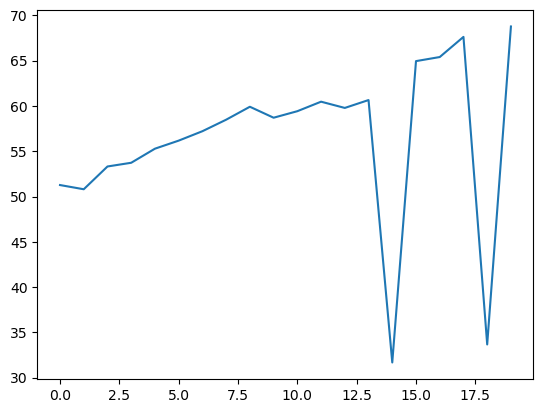

In [ ]:
print(env.positions_opened)
env.render(), next_step, #reward, # done, # plt.grid()

In [ ]:
env.observation_space

Box([[-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]
 [-inf]], [[inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]], (20, 1), float32)

In [ ]:
env.action_space.n

3